# Comparing Decision Trees and Naive Bayes for Heart Failure Prediction

In [1]:
# Notebook for Workshop: Compare DecisionTrees and Naive Bayes for Heart Failure Prediction
# https://hiof.instructure.com/courses/8923/assignments/41052

import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

I've added some markdown cells that provide some tips into how to discuss results. Note that my comments were made to a
particular run. Due the limitations with setup related to random sampling, we get different results each time we run. The discussions might therefore be slightly errornous when discussion concrete numbers, but they still provide valuable tips for how to discuss results.

In [2]:
# Load the dataset and show first 5 rows

dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

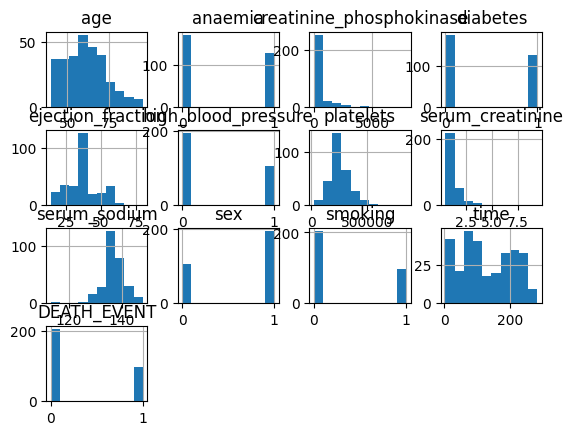

In [3]:
# Show the distribution of all the columns (both features and targets). We do this 
# to explore our data so that we better know how to proceed with the training.

dataset.hist()

We did this analysis to determine which version of naive bayes to use. We can see that some of the features are what we can consider normally distributed and some are binary. The normally distributed features aren't necessarily bell shaped like we would expect for normally distributed data, but they are closer to normally distributed than the alternative (binary/frequency).

The fact that we have two different types of distributions in our features means that we might have to create a custom classifier that combines a gaussian and bernoulli classifier to achieve optimal performance.

In [4]:
# Split into 60/20/20. 60% for training, 20% validation, and 20% for final testing

trainval = dataset.groupby('DEATH_EVENT', group_keys=False).apply(lambda x: x.sample(frac=0.8))
test = dataset.drop(trainval.index)
# 75% of 80% is 60% of total
train = trainval.groupby('DEATH_EVENT', group_keys=False).apply(lambda x: x.sample(frac=0.75))
validation = trainval.drop(train.index)

In [5]:
# Separate input features from targets in all partitions

train_features = train.drop('DEATH_EVENT', axis=1)
train_targets = train['DEATH_EVENT']

validation_features = validation.drop('DEATH_EVENT', axis=1)
validation_targets = validation['DEATH_EVENT']

test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test.DEATH_EVENT

In [6]:
# Train a classifier with default parameters

dt1 = DecisionTreeClassifier()
dt1.fit(train_features, train_targets)

DecisionTreeClassifier()

In [7]:
# Evaluate the performance of the classifier using the default metrics for classifiers, accuracy

dt1.score(validation_features, validation_targets)

0.7966101694915254

In [8]:
# A custom function for evaluation the performance using accuracy, precision, recall, f1 and roc_auc
# The final_eval parameter makes the evaluation include test data
def evaluate(model, final_eval=False):

    # Store the prediction probabilites and the predictions. We need the probabilities for 
    # roc_auc_score metric

    train_probabilities = model.predict_proba(train_features)
    # train_predictions = model.predict(train_features)
    # This does the same as the statement above without having the model predict again
    train_predictions = model.classes_.take(np.argmax(train_probabilities, axis=1), axis=0)
    validation_probabilities = model.predict_proba(validation_features)
    # validation_predictions = model.predict(validation_features)
    validation_predictions = model.classes_.take(np.argmax(validation_probabilities, axis=1), axis=0)

    # Print the training and validation scores

    print(f'Training Accuracy: {accuracy_score(train_targets, train_predictions)}')
    print(f'Training Precision: {precision_score(train_targets, train_predictions)}')
    print(f'Training Recall: {recall_score(train_targets, train_predictions)}')
    print(f'Training F1: {f1_score(train_targets, train_predictions)}')
    print(f'Training ROC AUC: {roc_auc_score(train_targets, train_probabilities[:,1])}')
    print(f'Validation Accuracy: {accuracy_score(validation_targets, validation_predictions)}')
    print(f'Validation Precision: {precision_score(validation_targets, validation_predictions)}')
    print(f'Validation Recall: {recall_score(validation_targets, validation_predictions)}')
    print(f'Validation F1: {f1_score(validation_targets, validation_predictions)}')
    print(f'Validation ROC AUC: {roc_auc_score(validation_targets, validation_probabilities[:,1])}')
    
    # Evaluate and print the final test scores if final_eval is True
    
    if final_eval:
        test_probabilities = model.predict_proba(test_features)
        test_predictions = model.classes_.take(np.argmax(test_probabilities, axis=1), axis=0)

        print(f'Test Accuracy: {accuracy_score(test_targets, test_predictions)}')
        print(f'Test Precision: {precision_score(test_targets, test_predictions)}')
        print(f'Test Recall: {recall_score(test_targets, test_predictions)}')
        print(f'Test F1: {f1_score(test_targets, test_predictions)}')
        print(f'Test ROC AUC: {roc_auc_score(test_targets, test_probabilities[:,1])}')


In [9]:
# Evaluate our model using our custom evaluate function

evaluate(dt1)

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1: 1.0
Training ROC AUC: 1.0
Validation Accuracy: 0.7966101694915254
Validation Precision: 0.6666666666666666
Validation Recall: 0.7368421052631579
Validation F1: 0.7
Validation ROC AUC: 0.780921052631579


Observations:
* model1 is highly overfitted, test results for f1 has dropped with almost 28 percentage points, other metrics have dropped significantly
* the model has a slignt tendency towards precision, meaning that the it is restrictive in predicting heart failures but that it is quite accurate when making the prediction


In [10]:
# Similar reports can be created using the builtin classification_report, but it is
# recommended to create your own

classification_report(validation_targets, dt1.predict(validation_features))

'              precision    recall  f1-score   support\n\n           0       0.87      0.82      0.85        40\n           1       0.67      0.74      0.70        19\n\n    accuracy                           0.80        59\n   macro avg       0.77      0.78      0.77        59\nweighted avg       0.80      0.80      0.80        59\n'

In [11]:
# Train a new classifier with max_depth set to 2 i.e. the produced decision tree will 
# never be deeper than 2 levels. This is a somewhat arbitraty choice of both parameter and 
# value. 

# Read the documentation for the classification algorithm to understand how the parameteres work, 
# and make different models based on your understanding of what might improve the results. 
# A random approach might also be a viable approach, but, with manual hyperparameter tuning, 
# this approach will take a long time. 
# 
# Note that you are expected to be able to explain and discuss how
# different hyperparameters affect results, both in the mandatory assignments and the 
# oral exam

dt2 = DecisionTreeClassifier(max_depth=2)
dt2.fit(train_features, train_targets)
evaluate(dt2)

Training Accuracy: 0.85
Training Precision: 0.7627118644067796
Training Recall: 0.7758620689655172
Training F1: 0.7692307692307693
Training ROC AUC: 0.8562747314867157
Validation Accuracy: 0.8305084745762712
Validation Precision: 0.68
Validation Recall: 0.8947368421052632
Validation F1: 0.7727272727272727
Validation ROC AUC: 0.8723684210526317


Observations
* This model is overfitted as well, but not to the same extent as the dt1 
* Like the first model, the model has better precision than recall, but here the tendency is much greater and we can see the trend in both the training and test results
* dt2 performs better than dt1 in all metrics (the same for recall) for validation data i.e. we must assume it is the best of the two

In [12]:
# Do final evaluation with the best models only. In this example we have only two, 
# so we test both.

evaluate(dt1, final_eval=True)
evaluate(dt2, final_eval=True)

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1: 1.0
Training ROC AUC: 1.0
Validation Accuracy: 0.7966101694915254
Validation Precision: 0.6666666666666666
Validation Recall: 0.7368421052631579
Validation F1: 0.7
Validation ROC AUC: 0.780921052631579
Test Accuracy: 0.75
Test Precision: 0.5833333333333334
Test Recall: 0.7368421052631579
Test F1: 0.6511627906976745
Test ROC AUC: 0.7464698331193839
Training Accuracy: 0.85
Training Precision: 0.7627118644067796
Training Recall: 0.7758620689655172
Training F1: 0.7692307692307693
Training ROC AUC: 0.8562747314867157
Validation Accuracy: 0.8305084745762712
Validation Precision: 0.68
Validation Recall: 0.8947368421052632
Validation F1: 0.7727272727272727
Validation ROC AUC: 0.8723684210526317
Test Accuracy: 0.8166666666666667
Test Precision: 0.6428571428571429
Test Recall: 0.9473684210526315
Test F1: 0.7659574468085106
Test ROC AUC: 0.8934531450577663


In [13]:
# Calculate the confusion matrix for the best decision tree model.

confusion_matrix(test_targets, dt2.predict(test_features))

array([[31, 10],
       [ 1, 18]])

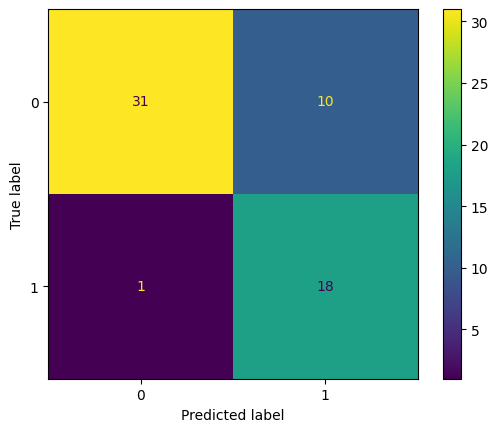

In [14]:
# The ConfusionMatrixDisplay class can be used to make confusion matrix plots

ConfusionMatrixDisplay.from_estimator(dt2, test_features, test_targets)

The confusion matrix show that dt2 is very accurate in it's predictions (precision), only two false positives. There are however 9 false negatives i.e. 9 failures that wasn't predicted. This could have dramatic consequences in practice.

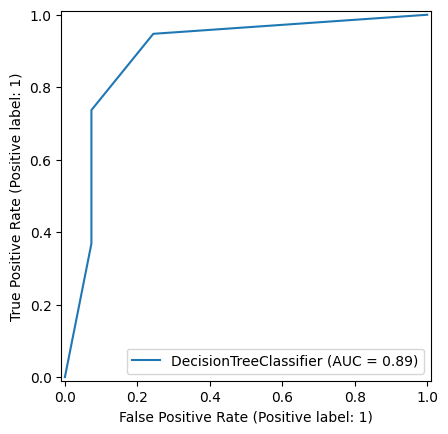

In [15]:
# Plot the ROC curve for the best decision tree model

# These two statements achieves the same thing
# RocCurveDisplay.from_predictions(test_targets, dt2.predict_proba(test_features)[:,1])
RocCurveDisplay.from_estimator(dt2, test_features, test_targets)

The ROC curve show very good performance for all sensitivities. This is also shown by the AUC of 0.84

In [16]:
# Train and evaluate a gaussian naive bayesian classifier with default parameters

nb1 = GaussianNB()
nb1.fit(train_features, train_targets)
evaluate(nb1)

Training Accuracy: 0.8
Training Precision: 0.8055555555555556
Training Recall: 0.5
Training F1: 0.6170212765957447
Training ROC AUC: 0.8723855285472017
Validation Accuracy: 0.8135593220338984
Validation Precision: 0.9
Validation Recall: 0.47368421052631576
Validation F1: 0.6206896551724138
Validation ROC AUC: 0.8131578947368421


* Slight overfitting, but nothing drastic. This fits with the fact that NB classifiers typically generalize better than many other ML algorithms, especially with a limited amount of data.
* Better precision than recall

In [17]:
# Train and evaluate Gaussian NB with 10 times the amount of smoothing to see if we can remove the 
# overfitting

nb2 = GaussianNB(var_smoothing=1e-8)
nb2.fit(train_features, train_targets)
evaluate(nb2)

Training Accuracy: 0.8
Training Precision: 0.8235294117647058
Training Recall: 0.4827586206896552
Training F1: 0.6086956521739131
Training ROC AUC: 0.8554267947993217
Validation Accuracy: 0.8135593220338984
Validation Precision: 1.0
Validation Recall: 0.42105263157894735
Validation F1: 0.5925925925925926
Validation ROC AUC: 0.8013157894736842


* Performs worse than nb1, perhaps a less drastic increase in smoothing should be tested

In [18]:
# Train and evaluate Gaussian NB with 10 times less smoothing

nb3 = GaussianNB(var_smoothing=1e-10)
nb3.fit(train_features, train_targets)
evaluate(nb3)

Training Accuracy: 0.8055555555555556
Training Precision: 0.8108108108108109
Training Recall: 0.5172413793103449
Training F1: 0.631578947368421
Training ROC AUC: 0.8754946297343131
Validation Accuracy: 0.8135593220338984
Validation Precision: 0.8333333333333334
Validation Recall: 0.5263157894736842
Validation F1: 0.6451612903225806
Validation ROC AUC: 0.8684210526315789


* More overfitting, which matches our expectation when less smoothing is applied
* Better than nb2, but seemingly not as good as nb1 for validation data 

In [19]:
# Compare the two best naive bayes classifiers. You should add more 
# models by testing other parameters and values. For Gaussian NB there is only one more 
# parameter to test

# A combined classifier that uses Gaussian NB for the continuous features and Bernoulli NB 
# for the binary features could also be tested as an alternative model.

evaluate(nb1, final_eval=True)
evaluate(nb3, final_eval=True)

Training Accuracy: 0.8
Training Precision: 0.8055555555555556
Training Recall: 0.5
Training F1: 0.6170212765957447
Training ROC AUC: 0.8723855285472017
Validation Accuracy: 0.8135593220338984
Validation Precision: 0.9
Validation Recall: 0.47368421052631576
Validation F1: 0.6206896551724138
Validation ROC AUC: 0.8131578947368421
Test Accuracy: 0.7166666666666667
Test Precision: 0.5833333333333334
Test Recall: 0.3684210526315789
Test F1: 0.45161290322580644
Test ROC AUC: 0.8318356867779204
Training Accuracy: 0.8055555555555556
Training Precision: 0.8108108108108109
Training Recall: 0.5172413793103449
Training F1: 0.631578947368421
Training ROC AUC: 0.8754946297343131
Validation Accuracy: 0.8135593220338984
Validation Precision: 0.8333333333333334
Validation Recall: 0.5263157894736842
Validation F1: 0.6451612903225806
Validation ROC AUC: 0.8684210526315789
Test Accuracy: 0.7333333333333333
Test Precision: 0.6153846153846154
Test Recall: 0.42105263157894735
Test F1: 0.5
Test ROC AUC: 0.826

* The two models performs exactly the same on test data, which makes us have to fall back to validation data in determining which models is the best
* nb1 is the better of the two for validation data. (Individual metrics should be discussed)

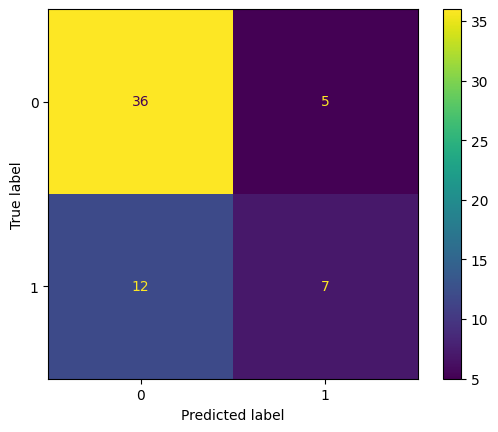

In [20]:
# Plot the confusion matrix for the best NB

ConfusionMatrixDisplay.from_estimator(nb1, test_features, test_targets)

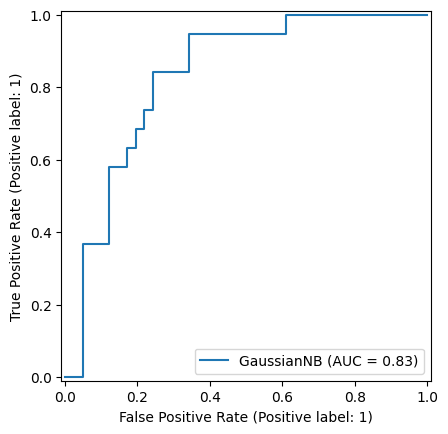

In [21]:
RocCurveDisplay.from_estimator(nb1, test_features, test_targets)

In [22]:
# Here you should add a collected presentation of all the results to make it easy to make the final 
# conclusion. I've kept it simple here by only showing the evaluation for the best classifiers of 
# both type

evaluate(dt2, final_eval=True)
evaluate(nb1, final_eval=True)

Training Accuracy: 0.85
Training Precision: 0.7627118644067796
Training Recall: 0.7758620689655172
Training F1: 0.7692307692307693
Training ROC AUC: 0.8562747314867157
Validation Accuracy: 0.8305084745762712
Validation Precision: 0.68
Validation Recall: 0.8947368421052632
Validation F1: 0.7727272727272727
Validation ROC AUC: 0.8723684210526317
Test Accuracy: 0.8166666666666667
Test Precision: 0.6428571428571429
Test Recall: 0.9473684210526315
Test F1: 0.7659574468085106
Test ROC AUC: 0.8934531450577663
Training Accuracy: 0.8
Training Precision: 0.8055555555555556
Training Recall: 0.5
Training F1: 0.6170212765957447
Training ROC AUC: 0.8723855285472017
Validation Accuracy: 0.8135593220338984
Validation Precision: 0.9
Validation Recall: 0.47368421052631576
Validation F1: 0.6206896551724138
Validation ROC AUC: 0.8131578947368421
Test Accuracy: 0.7166666666666667
Test Precision: 0.5833333333333334
Test Recall: 0.3684210526315789
Test F1: 0.45161290322580644
Test ROC AUC: 0.8318356867779204

Based on the metrics shown above we have to conclude that that dt2 is the best classifier for predicting heart failures. Both the confusion matrices and the ROC plots confirm the results. Both classifiers have a significant amount of false negatives, which makes both models complicate to implement in healthcare practice. 

The results are highly dependent on the random sampling in the data partitions. A more thorough analysis is needed to overcome this issue.